In [1]:
getwd()

[1] "D:/Working_Space/R_Working/lending_club"

In [2]:
#initial read
source("require_packages.R")
require_packages(c("tidyverse","stringr","forcats","lubridate"))
dataset <- read_csv("Lending Club Loan Status 2017Q2.csv")
#set syste locale
Sys.setlocale("LC_ALL","English")

#data cleaning
#loan_status: "Default" Deleted
dataset <- dataset %>%
    filter(!(loan_status == "Default"))
    
#change class of columns(to factor)
dataset <- dataset %>%
    mutate(term = as.factor(term),
           int_rate = as.numeric(str_sub(int_rate,start = 1L, end = -2L))/100,
           grade = as.factor(grade),
           sub_grade = as.factor(grade),
           emp_length =  fct_relevel(factor(emp_length),"10+ years",after = 10),
           home_ownership = as.factor(home_ownership),
           issue_d = as.Date(str_c("2017-",issue_d),format = "%Y-%b-%d"),
           loan_status = factor(loan_status,
                                   levels = c("Fully Paid","Current","In Grace Period","Late (16-30 days)","Late (31-120 days)","Charged Off")),
           purpose = as.factor(purpose),
           title = as.factor(title),
           application_type = as.factor(application_type))

dir.create("data")
saveRDS(dataset,"data/dataset.RData")

Loading required package: readr
Loading required package: stringr
Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 2.2.1     √ purrr   0.2.4
√ tibble  1.3.4     √ dplyr   0.7.4
√ tidyr   0.7.2     √ forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Parsed with column specification:
cols(
  .default = col_character(),
  id = col_integer(),
  loan_amnt = col_integer(),
  installment = col_double(),
  annual_inc = col_double(),
  dti = col_double(),
  delinq_2yrs = col_integer(),
  mths_since_last_delinq = col_integer(),
  revol_bal = col_integer(),
  total_rec_late_fee = col_double(),
  recoveries = col_integer(),
  tot_coll_amt = col_integer(),
  tot_cur_bal = 

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

Warning message in dir.create("data"):
"'data' already exists"

In [5]:
#set up
source("require_packages.R")
require_packages(c("tidyverse","stringr","forcats","lubridate","scales"))
dataset <- readRDS("data/dataset.RData")


In [10]:
#interactive variables
select_start_data <- 4
select_end_month <- 6
tracked_loan_type = "Fully Paid"
threshold_i <- 0.08

In [7]:
#display total numbers
source("setup.R")
#A glance of total loan amount; number of loans
#what's the order
# n_loan_status <- 6
# total_loan <- dataset %>%
#     group_by(loan_status) %>%
#     summarise(total_loan = sum(loan_amnt)) %>%
#     spread(key = loan_status, value = total_loan) %>%
#     mutate_(total_loan = sum(eval(parse(text = 
#                                             str_c(str_c(rep(".[[",n_loan_status),1:n_loan_status,"]]"),c(rep("+",n_loan_status-1),""),collapse = "")))));total_loan
# total_loan_v <- as.numeric(total_loan)
# names(total_loan_v) <- colnames(total_loan);total_loan_v
# #result in millions    
# total_loan_million_v <- str_c(round(total_loan/1000000,2),"m");total_loan_million
# names(total_loan_million_v) <- colnames(total_loan);total_loan_million_v
# 
# total_number_loans <- dataset %>%
#     group_by(loan_status) %>%
#     summarise(total_loan = n()) %>%
#     spread(key = loan_status, value = total_loan) %>%
#     mutate_(total_loan = sum(eval(parse(text = str_c(str_c(rep(".[[",n_loan_status),1:n_loan_status,"]]"),c(rep("+",n_loan_status-1),""),collapse = "")))));total_number_loans
# 
# total_number_loans_v <- as.numeric(total_number_loans)
# names(total_number_loans_v) <- colnames(total_loan);total_number_loans_v
total_numbers <- dataset %>%
    filter(month(issue_d) %in% c(select_start_data:select_end_month)) %>%
    group_by(loan_status) %>%
    summarise(sum_loan = sum(loan_amnt),num_loan = n()) %>%
    summarize(total_loan_amount = sum(sum_loan), total_number_of_loan = sum(num_loan))

total_numbers_display <- total_numbers %>%
    mutate(total_loan_amount = str_c("$",round(total_loan_amount/1000000),"M"),
           total_number_of_loan = format(total_number_of_loan,big.mark = ","));total_numbers_display

total_loan_amount,total_number_of_loan
$1538M,"105,450"


In [8]:
#Display by each status
# of notes by loan status YTD
# % of notes by loan status YTD
YTD_data <- dataset %>%
    filter(month(issue_d) %in% c(select_start_data:select_end_month)) %>%
    group_by(loan_status) %>%
    summarise(num_loan = n()) %>%
    mutate(pct_loan = num_loan/sum(num_loan)) 

YTD_disply <- YTD_data %>%
    mutate(pct_dispaly = str_c(round(pct_loan*100,2),"%")) %>%
    select(loan_status,num_loan,pct_dispaly)
    



YTD_table_display <- YTD_disply %>%
    rownames_to_column() %>% 
    gather(var, value, -rowname) %>% 
    spread(rowname, value) ;YTD_table_display

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

var,1,2,3,4,5,6
loan_status,Fully Paid,Current,In Grace Period,Late (16-30 days),Late (31-120 days),Charged Off
num_loan,7731,93683,1394,473,1711,458
pct_dispaly,7.33%,88.84%,1.32%,0.45%,1.62%,0.43%


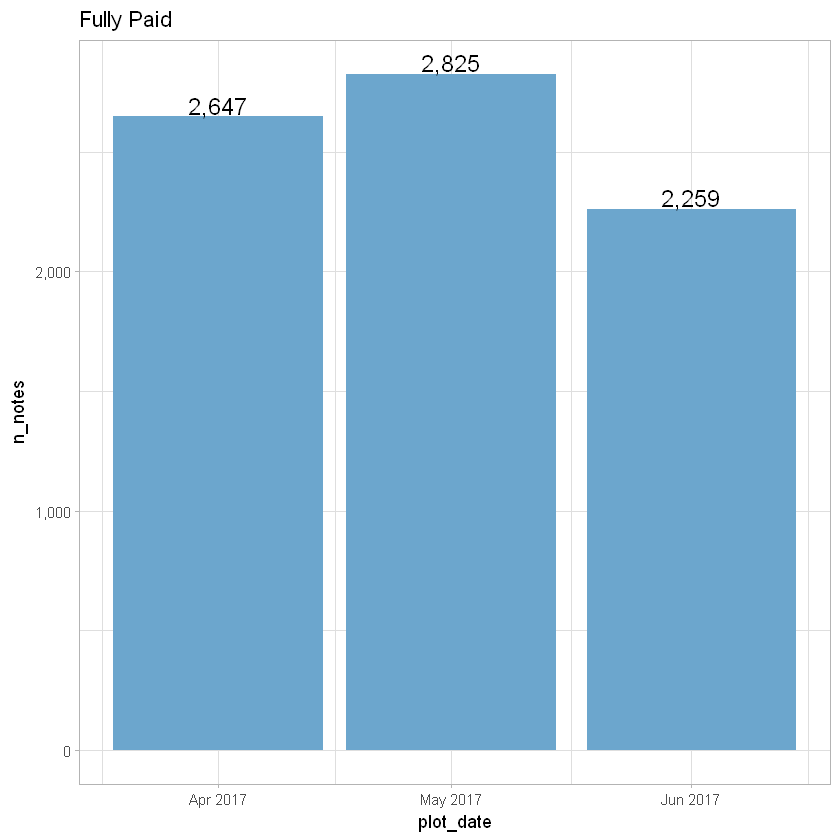

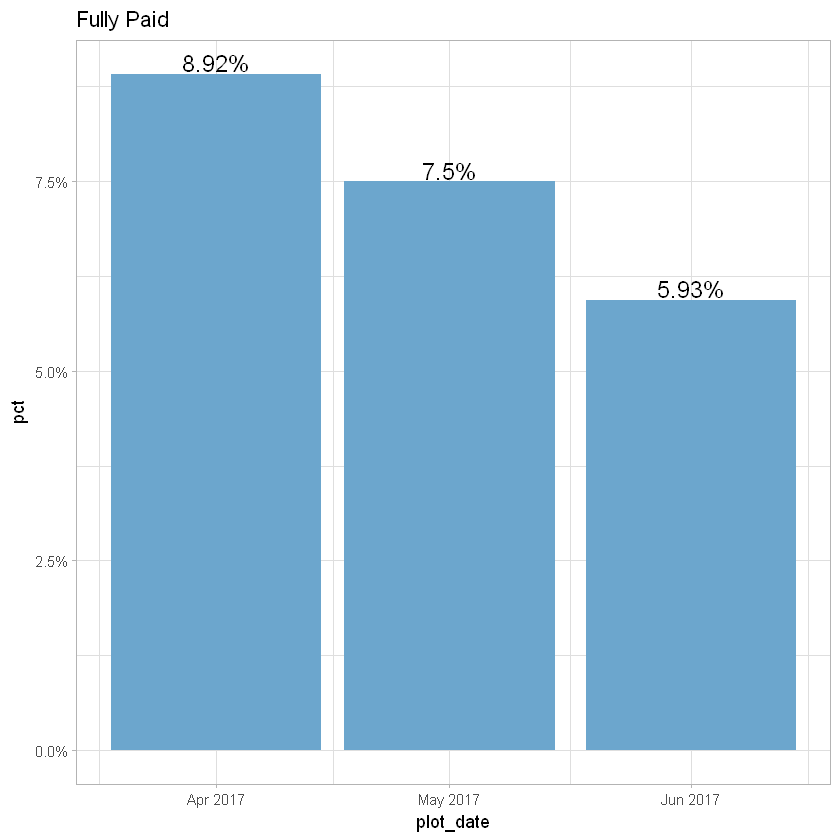

In [9]:
#track ratio and total number of the specific type
track_plot_data <- dataset %>%
    filter(month(issue_d) %in% c(select_start_data:select_end_month)) %>%
    group_by(issue_d,loan_status) %>%
    summarise(n_notes = n()) %>%
    mutate(ttl_notes = sum(n_notes),
           pct = n_notes/ttl_notes,
           plot_date = ymd(str_replace(issue_d,"[1-9]{2}$","01"))) %>%
    ungroup()

track_plot_data_specific <- track_plot_data %>%
    filter(loan_status ==tracked_loan_type)


track_plot_data_specific %>% 
    ggplot(mapping = aes(x = plot_date, y = n_notes)) +
    geom_col(fill = "skyblue3") +
    #aesthetics
    scale_x_date(date_labels = "%b %Y",date_breaks = "1 month") +
    scale_y_continuous(labels = comma) +
    theme_light() +
    labs(title = tracked_loan_type) +
    #layer of info
    geom_text(mapping = aes(y = n_notes,label = format(n_notes,big.mark = ",")),size = 5,vjust = -0.15)


track_plot_data_specific %>% 
    ggplot(mapping = aes(x = plot_date, y = pct)) +
    geom_col(fill = "skyblue3") +
    theme_light() +
    #aesthetics
    scale_y_continuous(labels = percent) +
    scale_x_date(date_labels = "%b %Y",date_breaks = "1 month") +
    labs(title = tracked_loan_type) +
    #layer of info
    geom_text(mapping = aes(y = pct,label = str_c(round(100*pct,2),"%")),size = 5,vjust = -0.15)




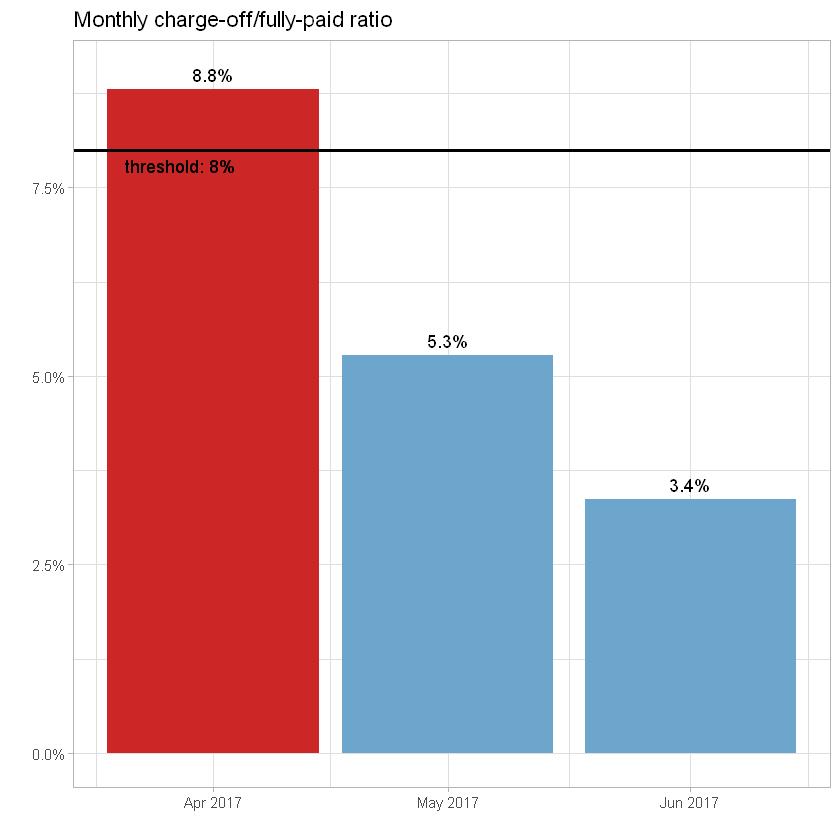

In [11]:
# dataset %>%
#     filter(select_month == month(issue_d)) %>%
#     group_by(loan_status) %>%
#     summarise(num_notes = n()) %>%
#     mutate(ratio = num_notes/sum(num_notes)) %>%
#     filter(loan_status == "Fully Paid" | loan_status == "Charged Off") %>%
#     mutate(type = if_else(loan_status == "Fully Paid",
#                           if_else(ratio < threshold_i,"bad","good"),
#                           if_else(ratio < threshold_i,"good","bad"))) %>%
#     ggplot(mapping = aes(x = loan_status, y = ratio)) +
#     geom_col(mapping = aes(fill = type)) +
#     #aesthetics below
#     scale_y_continuous(labels = percent) +
#     theme_light() +
#     theme(legend.position="none") +
#     #add extra info
#     geom_hline(yintercept = threshold_i, size = 1) +
#     geom_text(mapping = aes(x = 0.7, y = threshold_i - 0.002,label = str_c("threshold: ",threshold_i*100,"%"))) +
#     geom_text(mapping = aes(y = ratio + 0.002,label = str_c(signif(ratio*100,digits = 2),"%"))) +
#     scale_fill_manual(values = c(good = "skyblue3", bad = "firebrick3"))

#It seems like the purpose is to compare ratio between Fully Paid and Charged off

plot_data <- dataset %>%
    filter(month(issue_d) %in% c(select_start_data:select_end_month)) %>%
    group_by(issue_d,loan_status) %>%
    summarise(num_notes = n()) %>%
    filter(loan_status == "Fully Paid" | loan_status == "Charged Off") %>%
    spread(key = loan_status, value = num_notes) %>%
    ungroup() %>%
    mutate(ratio = .[[3]]/.[[2]],
           type = ifelse(ratio < threshold_i, "good", "bad"),
           plot_date = ymd(str_replace(issue_d,"[1-9]{2}$","01"))) 

plot_data %>%
    ggplot(mapping = aes(x = plot_date, y = ratio)) +
    geom_col(mapping = aes(fill = type)) +
    #aesthetics below
    scale_y_continuous(labels = percent) +
    theme_light() +
    theme(legend.position="none") +
    labs(x =  "", y = "", title = "Monthly charge-off/fully-paid ratio") +
    scale_x_date(date_labels = "%b %Y",date_breaks = "1 month") +
    #add extra info
    geom_hline(yintercept = threshold_i, size = 1) +
    geom_text(mapping = aes(x = min(plot_data$plot_date), y = threshold_i - 0.002,label = str_c("threshold: ",threshold_i*100,"%")),hjust = 0.8) +
    geom_text(mapping = aes(y = ratio + 0.002,label = str_c(signif(ratio*100,digits = 2),"%"))) +
    scale_fill_manual(values = c(good = "skyblue3", bad = "firebrick3")) 